In [1]:
import numpy as np
import pandas as pd

from keras.models import *
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from keras.losses import *
from keras import backend as K

import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.


1.14.1-dev20190607


In [130]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [2]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def symmetric_mean_absolute_mean_error(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

def calculate_rmse(x, y):
    return np.sum(np.absolute(x - y))/x.shape[0]

def calculate_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [13]:
train_df = pd.read_pickle('./preprocessed_train_df.pkl')
eval_df = pd.read_pickle('./preprocessed_eval_df.pkl')

In [14]:
dnn_feat = [
    'day', 'lat', 'long',
    'distance_from_qp09d8', 'distance_from_qp03xx', 'distance_from_qp03wf',
    'demand_t0', 'demand_t1', 'demand_t2', 'demand_t3', 'demand_t4', 'demand_t5', 'demand_t6', 'demand_t7',
    'demand_7d_t0', 'demand_7d_t1', 'demand_7d_t2', 'demand_7d_t3',
    'demand_7d_t4', 'demand_7d_t5', 'demand_7d_t6', 'demand_7d_t7', 'demand_7d_t8',
    'demand_7d_t9', 'demand_7d_t10', 'demand_7d_t11', 'demand_7d_t12',
    'day_mod_seven', 'day_of_week_sin', 'day_of_week_cos',
    'hour', 'hour_sin', 'hour_cos',
    'per_fifteen_minutes', 'fifteen_minute_sin', 'fifteen_minute_cos',
    'day_of_week_median', 'day_of_week_mean',
    'hour_median', 'hour_mean',
    'per_fifteen_minutes_median', 'per_fifteen_minutes_mean'
]

target = ['target_1', 'target_2', 'target_3', 'target_4', 'target_5']

In [15]:
X_train = train_df[dnn_feat]
Y_train = train_df[target]
X_eval = eval_df[dnn_feat]
Y_eval = eval_df[target]

In [39]:
# Raw DNN
dnn_inputs = Input(shape=(len(dnn_feat),))

dnn = Dense(256, activation=relu)(dnn_inputs)
dnn = Dense(128, activation=relu)(dnn)
dnn = Dense(64, activation=relu)(dnn)
dnn = Dense(32, activation=relu)(dnn)
dnn = Dense(5, activation=hard_sigmoid)(dnn)

dnn = Model(inputs=dnn_inputs, outputs=dnn)

dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 42)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               11008     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 165       
Total params: 54,405
Trainable params: 54,405
Non-trainable params: 0
_________________________________________________________________


In [40]:
dnn.compile(optimizer=Adagrad(lr=1e-4), loss=mean_squared_error, metrics=[root_mean_squared_error],)
dnn.fit(X_train, Y_train, batch_size=256, epochs=32, validation_data=(X_eval, Y_eval))

Train on 5609709 samples, validate on 1267866 samples
Epoch 1/32
5609709/5609709 [==============================] - 121s 22us/step - loss: 0.0095 - root_mean_squared_error: 0.0943 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0585
Epoch 2/32
5609709/5609709 [==============================] - 114s 20us/step - loss: 0.0023 - root_mean_squared_error: 0.0471 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0446
Epoch 3/32
5609709/5609709 [==============================] - 108s 19us/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0391
Epoch 4/32
5609709/5609709 [==============================] - 106s 19us/step - loss: 0.0015 - root_mean_squared_error: 0.0380 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0370
Epoch 5/32
5609709/5609709 [==============================] - 77s 14us/step - loss: 0.0015 - root_mean_squared_error: 0.0375 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0361
Epoch 6/32
5609709/5609709 [====

In [42]:
dnn_rmse = []
for gh in eval_df.geohash6.unique():
    gh_df = eval_df[eval_df.geohash6 == gh]
    preds = dnn.predict(gh_df[dnn_feat])
    actual = gh_df[target]
    dnn_rmse.append({
        'geohash6': gh,
        'rmse(t+1)': calculate_rmse(actual['target_1'], preds[:, 0]),
        'rmse(t+2)': calculate_rmse(actual['target_2'], preds[:, 1]),
        'rmse(t+3)': calculate_rmse(actual['target_3'], preds[:, 2]),
        'rmse(t+4)': calculate_rmse(actual['target_4'], preds[:, 3]),
        'rmse(t+5)': calculate_rmse(actual['target_5'], preds[:, 4]),
        'smape(t+1)': calculate_smape(actual['target_1'], preds[:, 0]),
        'smape(t+2)': calculate_smape(actual['target_2'], preds[:, 1]),
        'smape(t+3)': calculate_smape(actual['target_3'], preds[:, 2]),
        'smape(t+4)': calculate_smape(actual['target_4'], preds[:, 3]),
        'smape(t+5)': calculate_smape(actual['target_5'], preds[:, 4]),
    })

dnn_rmse_df = pd.DataFrame(dnn_rmse)
dnn_rmse_df.describe()

,rmse(t+1),rmse(t+2),rmse(t+3),rmse(t+4),rmse(t+5),smape(t+1),smape(t+2),smape(t+3),smape(t+4),smape(t+5)
count,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000
mean,0.025473,0.020247,0.019033,0.025220,0.025337,91.858744,85.225668,66.229303,97.234436,93.166287
std,0.013625,0.016905,0.018620,0.017385,0.019727,37.048011,35.490787,20.229661,41.824110,36.982582
min,0.012190,0.004835,0.001880,0.010578,0.009618,6.669425,7.361408,6.745487,7.555364,9.072621
25%,0.016100,0.009202,0.005417,0.014472,0.012802,60.699358,58.090186,53.744591,63.572445,64.166834
50%,0.021544,0.014116,0.013629,0.018764,0.018398,99.547916,87.879607,67.234624,97.904210,94.609403
75%,0.029078,0.024048,0.025175,0.028752,0.029653,124.528302,113.514053,81.382137,132.349672,128.165475
max,0.118859,0.125462,0.129375,0.135433,0.148625,150.025986,160.703211,136.898660,175.302296,168.419975


In [43]:
dnn_rmse_df.to_csv('./dnn_01.csv', index=False)

In [44]:
import matplotlib.pyplot as plt

In [46]:
X_eval.columns

Index(['day', 'lat', 'long', 'distance_from_qp09d8', 'distance_from_qp03xx',
       'distance_from_qp03wf', 'demand_t0', 'demand_t1', 'demand_t2',
       'demand_t3', 'demand_t4', 'demand_t5', 'demand_t6', 'demand_t7',
       'demand_7d_t0', 'demand_7d_t1', 'demand_7d_t2', 'demand_7d_t3',
       'demand_7d_t4', 'demand_7d_t5', 'demand_7d_t6', 'demand_7d_t7',
       'demand_7d_t8', 'demand_7d_t9', 'demand_7d_t10', 'demand_7d_t11',
       'demand_7d_t12', 'day_mod_seven', 'day_of_week_sin', 'day_of_week_cos',
       'hour', 'hour_sin', 'hour_cos', 'per_fifteen_minutes',
       'fifteen_minute_sin', 'fifteen_minute_cos', 'day_of_week_median',
       'day_of_week_mean', 'hour_median', 'hour_mean',
       'per_fifteen_minutes_median', 'per_fifteen_minutes_mean'],
      dtype='object')

In [71]:
from matplotlib.pyplot import figure
import random

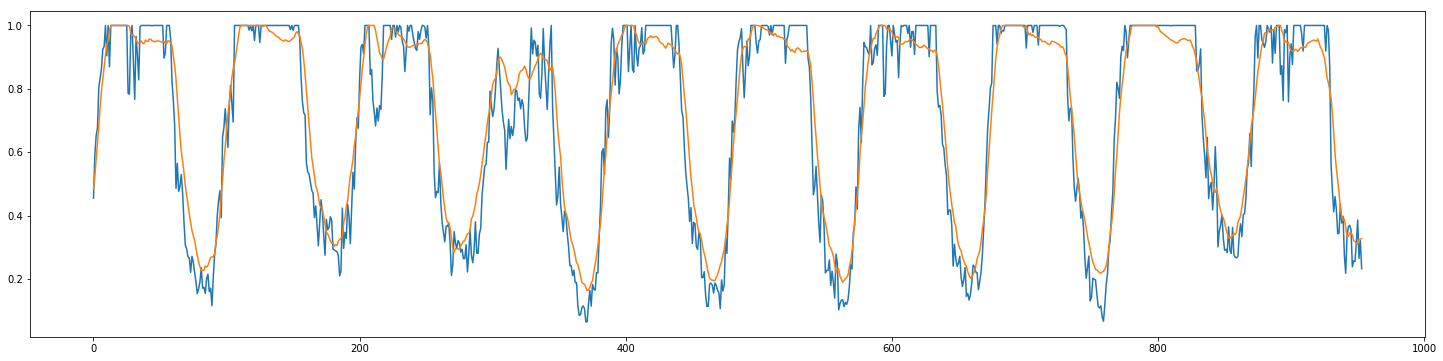

In [96]:
TEST_GEOHASH = random.choice(eval_df.geohash6.unique())
# TEST_GEOHASH = 'qp09d8'
X_preds = eval_df[eval_df.geohash6 == TEST_GEOHASH][dnn_feat]
Y_preds = dnn.predict(X_preds)

figure(num=None, figsize=(25, 6))
plt.plot(np.arange(X_eval[eval_df.geohash6 == TEST_GEOHASH].shape[0]), Y_eval[eval_df.geohash6 == TEST_GEOHASH].target_1)
plt.plot(np.arange(X_eval[eval_df.geohash6 == TEST_GEOHASH].shape[0]), Y_preds[:, 0])

In [99]:
!mkdir target_2

In [101]:
for TEST_GEOHASH in eval_df.geohash6.unique():
    X_preds = eval_df[eval_df.geohash6 == TEST_GEOHASH][dnn_feat]
    Y_preds = dnn.predict(X_preds)
    figure(num=None, figsize=(25, 6))
    plt.plot(np.arange(X_eval[eval_df.geohash6 == TEST_GEOHASH].shape[0]), Y_eval[eval_df.geohash6 == TEST_GEOHASH].target_2)
    plt.plot(np.arange(X_eval[eval_df.geohash6 == TEST_GEOHASH].shape[0]), Y_preds[:, 1])
    plt.savefig('./target_2/{0}.png'.format(TEST_GEOHASH))
    plt.close('all')

In [102]:
!mkdir target_3
!mkdir target_4
!mkdir target_5

In [103]:
for TEST_GEOHASH in eval_df.geohash6.unique():
    X_preds = eval_df[eval_df.geohash6 == TEST_GEOHASH][dnn_feat]
    Y_preds = dnn.predict(X_preds)
    figure(num=None, figsize=(25, 6))
    plt.plot(np.arange(X_eval[eval_df.geohash6 == TEST_GEOHASH].shape[0]), Y_eval[eval_df.geohash6 == TEST_GEOHASH].target_3)
    plt.plot(np.arange(X_eval[eval_df.geohash6 == TEST_GEOHASH].shape[0]), Y_preds[:, 2])
    plt.savefig('./target_3/{0}.png'.format(TEST_GEOHASH))
    plt.close('all')

In [104]:
for TEST_GEOHASH in eval_df.geohash6.unique():
    X_preds = eval_df[eval_df.geohash6 == TEST_GEOHASH][dnn_feat]
    Y_preds = dnn.predict(X_preds)
    figure(num=None, figsize=(25, 6))
    plt.plot(np.arange(X_eval[eval_df.geohash6 == TEST_GEOHASH].shape[0]), Y_eval[eval_df.geohash6 == TEST_GEOHASH].target_4)
    plt.plot(np.arange(X_eval[eval_df.geohash6 == TEST_GEOHASH].shape[0]), Y_preds[:, 3])
    plt.savefig('./target_4/{0}.png'.format(TEST_GEOHASH))
    plt.close('all')

In [105]:
for TEST_GEOHASH in eval_df.geohash6.unique():
    X_preds = eval_df[eval_df.geohash6 == TEST_GEOHASH][dnn_feat]
    Y_preds = dnn.predict(X_preds)
    figure(num=None, figsize=(25, 6))
    plt.plot(np.arange(X_eval[eval_df.geohash6 == TEST_GEOHASH].shape[0]), Y_eval[eval_df.geohash6 == TEST_GEOHASH].target_5)
    plt.plot(np.arange(X_eval[eval_df.geohash6 == TEST_GEOHASH].shape[0]), Y_preds[:, 4])
    plt.savefig('./target_5/{0}.png'.format(TEST_GEOHASH))
    plt.close('all')

In [3]:
train_df = pd.read_pickle('./preprocessed_train_df_with_daily.pkl')
eval_df = pd.read_pickle('./preprocessed_eval_df_with_daily.pkl')

In [4]:
raw_feat = [
    'day', 'lat', 'long',
    'distance_from_qp09d8', 'distance_from_qp03xx', 'distance_from_qp03wf',
    'demand_t0', 'demand_t1', 'demand_t2', 'demand_t3', 'demand_t4', 'demand_t5', 'demand_t6', 'demand_t7',
    'day_mod_seven', 'day_of_week_sin', 'day_of_week_cos',
    'hour', 'hour_sin', 'hour_cos',
    'per_fifteen_minutes', 'fifteen_minute_sin', 'fifteen_minute_cos',
    'day_of_week_median', 'day_of_week_mean',
    'hour_median', 'hour_mean',
    'per_fifteen_minutes_median', 'per_fifteen_minutes_mean'
]

last_six_day_feat = []
for d in [6, 5, 4, 3, 2, 1]:
    for i in range(13):
        last_six_day_feat.append('demand_{0}d_t{1}'.format(d, i))

last_week_today_feat = ['demand_7d_t{0}'.format(i) for i in range(13)]

target = ['target_1', 'target_2', 'target_3', 'target_4', 'target_5']

In [9]:
X_train_raw = train_df[raw_feat]
X_eval_raw = eval_df[raw_feat]

X_train_last_week = train_df[last_week_today_feat]
X_eval_last_week = eval_df[last_week_today_feat]

X_train_last_six_day = train_df[last_six_day_feat]
X_eval_last_six_day = eval_df[last_six_day_feat]

Y_train = train_df[target]
Y_eval = eval_df[target]

In [37]:
raw_inputs = Input(shape=(len(raw_feat),))
last_week_today_inputs = Input(shape=(len(last_week_today_feat),))
last_six_day_inputs = Input(shape=(len(last_six_day_feat),))

daily_cnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_cnn = Reshape((7, len(last_week_today_feat),))(daily_cnn)
daily_cnn = Conv1D(16, 5, activation=selu, padding='same')(daily_cnn)
daily_cnn = MaxPool1D(2, 2, padding='same')(daily_cnn)
daily_cnn = Conv1D(32, 3, activation=selu, padding='same')(daily_cnn)
daily_cnn = MaxPool1D(2, 2, padding='same')(daily_cnn)
daily_cnn = Flatten()(daily_cnn)
daily_cnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_cnn)

# last_week_today_inputs act as attention
final_stacked = concatenate([raw_inputs, daily_cnn.output, last_week_today_inputs])
final_stacked = Dense(256, activation=selu)(final_stacked)
final_stacked = Dense(128, activation=selu)(final_stacked)
final_stacked = Dense(32, activation=selu)(final_stacked)
final_stacked = Dense(5, activation=hard_sigmoid)(final_stacked)
final_stacked = Model(inputs=[raw_inputs, last_week_today_inputs, last_six_day_inputs], outputs=final_stacked)

final_stacked.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 13)           0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           (None, 78)           0                                            
__________________________________________________________________________________________________
concatenate_27 (Concatenate)    (None, 91)           0           input_41[0][0]                   
                                                                 input_42[0][0]                   
__________________________________________________________________________________________________
reshape_14 (Reshape)            (None, 7, 13)        0           concatenate_27[0][0]             
__________

In [38]:
final_stacked.compile(optimizer=Adagrad(lr=1e-4), loss=mean_squared_error, metrics=[root_mean_squared_error],)
final_stacked.fit(
    [X_train_raw, X_train_last_week, X_train_last_six_day], Y_train,
    batch_size=256, epochs=8,
    validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day], Y_eval))

Train on 5609709 samples, validate on 1267866 samples
Epoch 1/8
5609709/5609709 [==============================] - 181s 32us/step - loss: 0.0120 - root_mean_squared_error: 0.1084 - val_loss: 0.0146 - val_root_mean_squared_error: 0.0685
Epoch 2/8
5609709/5609709 [==============================] - 180s 32us/step - loss: 0.0119 - root_mean_squared_error: 0.1076 - val_loss: 0.0145 - val_root_mean_squared_error: 0.0682
Epoch 3/8
1169152/5609709 [=====>........................] - ETA: 2:11 - loss: 0.0118 - root_mean_squared_error: 0.1075

E0616 13:32:01.973729 4452001216 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-7593fd6d8695>", line 5, in <module>
    validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day], Y_eval))
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/engine/training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/engine/training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 2697, in __call__
    if hasattr(get_session(), '_make_callable_from_options'):
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 193, in get_session
    if not getattr(v, '_keras_initialized', False):
KeyboardInterrupt

Du

KeyboardInterrupt: 

In [ ]:
cnn_dnn_rmse = []
for gh in eval_df.geohash6.unique():
    gh_df = eval_df[eval_df.geohash6 == gh]
    preds = final_stacked.predict([gh_df[raw_feat], gh_df[last_week_today_feat], gh_df[last_six_day_feat]])
    actual = gh_df[target]
    cnn_dnn_rmse.append({
        'geohash6': gh,
        'rmse(t+1)': calculate_rmse(actual['target_1'], preds[:, 0]),
        'rmse(t+2)': calculate_rmse(actual['target_2'], preds[:, 1]),
        'rmse(t+3)': calculate_rmse(actual['target_3'], preds[:, 2]),
        'rmse(t+4)': calculate_rmse(actual['target_4'], preds[:, 3]),
        'rmse(t+5)': calculate_rmse(actual['target_5'], preds[:, 4]),
        'smape(t+1)': calculate_smape(actual['target_1'], preds[:, 0]),
        'smape(t+2)': calculate_smape(actual['target_2'], preds[:, 1]),
        'smape(t+3)': calculate_smape(actual['target_3'], preds[:, 2]),
        'smape(t+4)': calculate_smape(actual['target_4'], preds[:, 3]),
        'smape(t+5)': calculate_smape(actual['target_5'], preds[:, 4]),
    })
cnn_dnn_rmse_df = pd.DataFrame(cnn_dnn_rmse)
cnn_dnn_rmse_df.describe()

In [52]:
raw_inputs = Input(shape=(len(raw_feat),))
last_week_today_inputs = Input(shape=(len(last_week_today_feat),))
last_six_day_inputs = Input(shape=(len(last_six_day_feat),))

daily_rnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_rnn = Reshape((7, len(last_week_today_feat),))(daily_rnn)
daily_rnn = GRU(32, return_sequences=True)(daily_rnn)
daily_rnn = GRU(16)(daily_rnn)
daily_rnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_rnn)

# last_week_today_inputs act as attention
final_stacked = concatenate([raw_inputs, daily_rnn.output, last_week_today_inputs])
final_stacked = Dense(128, activation=selu)(final_stacked)
final_stacked = Dropout(0.5)(final_stacked)
final_stacked = Dense(64, activation=selu)(final_stacked)
final_stacked = Dropout(0.5)(final_stacked)
final_stacked = Dense(32, activation=selu)(final_stacked)
final_stacked = Dense(5, activation=hard_sigmoid)(final_stacked)
final_stacked = Model(inputs=[raw_inputs, last_week_today_inputs, last_six_day_inputs], outputs=final_stacked)

final_stacked.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           (None, 13)           0                                            
__________________________________________________________________________________________________
input_66 (InputLayer)           (None, 78)           0                                            
__________________________________________________________________________________________________
concatenate_42 (Concatenate)    (None, 91)           0           input_65[0][0]                   
                                                                 input_66[0][0]                   
__________________________________________________________________________________________________
reshape_22 (Reshape)            (None, 7, 13)        0           concatenate_42[0][0]             
__________

In [53]:
final_stacked.compile(optimizer=Adam(lr=3e-5), loss=mean_squared_error, metrics=[root_mean_squared_error],)
final_stacked.fit(
    [X_train_raw, X_train_last_week, X_train_last_six_day], Y_train,
    batch_size=256, epochs=16,
    validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day], Y_eval))

Train on 5609709 samples, validate on 1267866 samples
Epoch 1/16
 982272/5609709 [====>.........................] - ETA: 5:20 - loss: 0.0414 - root_mean_squared_error: 0.1815

KeyboardInterrupt: 

In [ ]:
rnn_dnn_rmse = []
for gh in eval_df.geohash6.unique():
    gh_df = eval_df[eval_df.geohash6 == gh]
    preds = final_stacked.predict([gh_df[raw_feat], gh_df[last_week_today_feat], gh_df[last_six_day_feat]])
    actual = gh_df[target]
    rnn_dnn_rmse.append({
        'geohash6': gh,
        'rmse(t+1)': calculate_rmse(actual['target_1'], preds[:, 0]),
        'rmse(t+2)': calculate_rmse(actual['target_2'], preds[:, 1]),
        'rmse(t+3)': calculate_rmse(actual['target_3'], preds[:, 2]),
        'rmse(t+4)': calculate_rmse(actual['target_4'], preds[:, 3]),
        'rmse(t+5)': calculate_rmse(actual['target_5'], preds[:, 4]),
        'smape(t+1)': calculate_smape(actual['target_1'], preds[:, 0]),
        'smape(t+2)': calculate_smape(actual['target_2'], preds[:, 1]),
        'smape(t+3)': calculate_smape(actual['target_3'], preds[:, 2]),
        'smape(t+4)': calculate_smape(actual['target_4'], preds[:, 3]),
        'smape(t+5)': calculate_smape(actual['target_5'], preds[:, 4]),
    })
rnn_dnn_rmse_df = pd.DataFrame(rnn_dnn_rmse)
rnn_dnn_rmse_df.describe()

In [65]:
raw_inputs = Input(shape=(len(raw_feat),))
last_week_today_inputs = Input(shape=(len(last_week_today_feat),))
last_six_day_inputs = Input(shape=(len(last_six_day_feat),))

daily_cnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_cnn = Reshape((7, len(last_week_today_feat),))(daily_cnn)
daily_cnn = Conv1D(16, 5, activation=selu, padding='same')(daily_cnn)
daily_cnn = MaxPool1D(2, 2, padding='same')(daily_cnn)
daily_cnn = Conv1D(8, 3, activation=selu, padding='same')(daily_cnn)
daily_cnn = MaxPool1D(2, 2, padding='same')(daily_cnn)
daily_cnn = Flatten()(daily_cnn)
daily_cnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_cnn)

daily_rnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_rnn = Reshape((7, len(last_week_today_feat),))(daily_rnn)
daily_rnn = GRU(32, return_sequences=True)(daily_rnn)
daily_rnn = GRU(16)(daily_rnn)
daily_rnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_rnn)

# last_week_today_inputs act as attention
final_stacked = concatenate([raw_inputs, daily_rnn.output, daily_cnn.output, last_week_today_inputs])
final_stacked = Dense(256, activation=selu)(final_stacked)
final_stacked = Dense(128, activation=selu)(final_stacked)
final_stacked = Dense(32, activation=selu)(final_stacked)
final_stacked = Dense(5, activation=hard_sigmoid)(final_stacked)
final_stacked = Model(inputs=[raw_inputs, last_week_today_inputs, last_six_day_inputs], outputs=final_stacked)

final_stacked.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_86 (InputLayer)           (None, 13)           0                                            
__________________________________________________________________________________________________
input_87 (InputLayer)           (None, 78)           0                                            
__________________________________________________________________________________________________
concatenate_61 (Concatenate)    (None, 91)           0           input_86[0][0]                   
                                                                 input_87[0][0]                   
__________________________________________________________________________________________________
reshape_35 (Reshape)            (None, 7, 13)        0           concatenate_61[0][0]             
__________

In [68]:
final_stacked.compile(optimizer=Adam(lr=3e-4), loss=mean_squared_error, metrics=[root_mean_squared_error],)
final_stacked.fit(
    [X_train_raw, X_train_last_week, X_train_last_six_day], Y_train,
    batch_size=256, epochs=16,
    validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day], Y_eval))

Train on 5609709 samples, validate on 1267866 samples
Epoch 1/16
1981952/5609709 [=========>....................] - ETA: 4:10 - loss: 0.1968 - root_mean_squared_error: 0.4436

E0616 13:43:14.800544 4452001216 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-68-daa5d526df65>", line 5, in <module>
    validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day], Y_eval))
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/engine/training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/engine/training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 2675, in _call
    fetched = self._callable_fn(*array_vals)
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/tensorfl

KeyboardInterrupt: 

In [ ]:
rnn_dnn_rmse = []
for gh in eval_df.geohash6.unique():
    gh_df = eval_df[eval_df.geohash6 == gh]
    preds = final_stacked.predict([gh_df[raw_feat], gh_df[last_week_today_feat], gh_df[last_six_day_feat]])
    actual = gh_df[target]
    rnn_dnn_rmse.append({
        'geohash6': gh,
        'rmse(t+1)': calculate_rmse(actual['target_1'], preds[:, 0]),
        'rmse(t+2)': calculate_rmse(actual['target_2'], preds[:, 1]),
        'rmse(t+3)': calculate_rmse(actual['target_3'], preds[:, 2]),
        'rmse(t+4)': calculate_rmse(actual['target_4'], preds[:, 3]),
        'rmse(t+5)': calculate_rmse(actual['target_5'], preds[:, 4]),
        'smape(t+1)': calculate_smape(actual['target_1'], preds[:, 0]),
        'smape(t+2)': calculate_smape(actual['target_2'], preds[:, 1]),
        'smape(t+3)': calculate_smape(actual['target_3'], preds[:, 2]),
        'smape(t+4)': calculate_smape(actual['target_4'], preds[:, 3]),
        'smape(t+5)': calculate_smape(actual['target_5'], preds[:, 4]),
    })
rnn_dnn_rmse_df = pd.DataFrame(rnn_dnn_rmse)
rnn_dnn_rmse_df.describe()

In [83]:
raw_inputs = Input(shape=(len(raw_feat),))
last_week_today_inputs = Input(shape=(len(last_week_today_feat),))
last_six_day_inputs = Input(shape=(len(last_six_day_feat),))

daily_cnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_cnn = Reshape((7, len(last_week_today_feat),))(daily_cnn)
daily_cnn = Conv1D(16, 5, activation=relu, padding='same')(daily_cnn)
daily_cnn = MaxPool1D(2, 2, padding='same')(daily_cnn)
daily_cnn = Conv1D(8, 3, activation=relu, padding='same')(daily_cnn)
daily_cnn = MaxPool1D(2, 2, padding='same')(daily_cnn)
daily_cnn = Flatten()(daily_cnn)
daily_cnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_cnn)

daily_rnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_rnn = Reshape((7, len(last_week_today_feat),))(daily_rnn)
daily_rnn = GRU(32, return_sequences=True)(daily_rnn)
daily_rnn = GRU(16)(daily_rnn)
daily_rnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_rnn)

raw_dnn = Dense(128, activation=relu)(raw_inputs)
raw_dnn = Dense(64, activation=relu)(raw_dnn)
raw_dnn = Dense(32, activation=relu)(raw_dnn)
raw_dnn = Model(inputs=raw_inputs, outputs=raw_dnn)

attention_dnn = Dense(64, activation=relu)(last_week_today_inputs)
attention_dnn = Dense(32, activation=relu)(attention_dnn)
attention_dnn = Dense(16, activation=relu)(attention_dnn)
attention_dnn = Model(inputs=last_week_today_inputs, outputs=attention_dnn)

# last_week_today_inputs act as attention
final_stacked = concatenate([raw_dnn.output, daily_rnn.output, daily_cnn.output, attention_dnn.output])
final_stacked = Dense(256, activation=selu)(final_stacked)
final_stacked = Dense(128, activation=selu)(final_stacked)
final_stacked = Dense(32, activation=selu)(final_stacked)
final_stacked = Dense(5, activation=hard_sigmoid)(final_stacked)
final_stacked = Model(inputs=[raw_inputs, last_week_today_inputs, last_six_day_inputs], outputs=final_stacked)

final_stacked.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_107 (InputLayer)          (None, 13)           0                                            
__________________________________________________________________________________________________
input_108 (InputLayer)          (None, 78)           0                                            
__________________________________________________________________________________________________
concatenate_80 (Concatenate)    (None, 91)           0           input_107[0][0]                  
                                                                 input_108[0][0]                  
__________________________________________________________________________________________________
reshape_49 (Reshape)            (None, 7, 13)        0           concatenate_80[0][0]             
__________

In [84]:
final_stacked.compile(optimizer=Adagrad(lr=0.003), loss=mean_squared_error, metrics=[root_mean_squared_error],)
final_stacked.fit(
    [X_train_raw, X_train_last_week, X_train_last_six_day], Y_train,
    batch_size=256, epochs=1,
    validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day], Y_eval))

Train on 5609709 samples, validate on 1267866 samples
Epoch 1/1
5609216/5609709 [============================>.] - ETA: 0s - loss: 0.0190 - root_mean_squared_error: 0.1362

E0616 13:58:23.069545 4452001216 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-84-30c59dad259b>", line 5, in <module>
    validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day], Y_eval))
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/engine/training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/engine/training_arrays.py", line 212, in fit_loop
    verbose=0)
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/engine/training_arrays.py", line 388, in test_loop
    ins_batch = slice_arrays(ins, batch_ids)
  File "/anaconda3/envs/grab/lib/python3.7/site-packages/keras/utils/generic_utils.py", line 526, in slice_arrays
    return [None if x is None else x[start] for x in arrays]
  File "/anaconda3/envs/grab/lib/python3.7/site-

KeyboardInterrupt: 

In [108]:
raw_feat = [
    'day', 'lat', 'long',
    'distance_from_qp09d8', 'distance_from_qp03xx', 'distance_from_qp03wf',
    'day_mod_seven', 'day_of_week_sin', 'day_of_week_cos',
    'hour', 'hour_sin', 'hour_cos',
    'per_fifteen_minutes', 'fifteen_minute_sin', 'fifteen_minute_cos',
    'day_of_week_median', 'day_of_week_mean',
    'hour_median', 'hour_mean',
    'per_fifteen_minutes_median', 'per_fifteen_minutes_mean'
]

last_two_hour_feat = ['demand_t{0}'.format(t) for t in range(7, -1, -1)]

last_six_day_feat = []
for d in [6, 5, 4, 3, 2, 1]:
    for i in range(13):
        last_six_day_feat.append('demand_{0}d_t{1}'.format(d, i))

last_week_today_feat = ['demand_7d_t{0}'.format(i) for i in range(13)]

target = ['target_1', 'target_2', 'target_3', 'target_4', 'target_5']

In [86]:
X_train_raw = train_df[raw_feat]
X_eval_raw = eval_df[raw_feat]

X_train_last_two_hour = train_df[last_two_hour_feat]
X_eval_last_two_hour = eval_df[last_two_hour_feat]

X_train_last_week = train_df[last_week_today_feat]
X_eval_last_week = eval_df[last_week_today_feat]

X_train_last_six_day = train_df[last_six_day_feat]
X_eval_last_six_day = eval_df[last_six_day_feat]

Y_train = train_df[target]
Y_eval = eval_df[target]

In [ ]:
raw_inputs = Input(shape=(len(raw_feat),))
last_two_hour_inputs = Input(shape=(len(last_two_hour_feat),))
last_week_today_inputs = Input(shape=(len(last_week_today_feat),))
last_six_day_inputs = Input(shape=(len(last_six_day_feat),))

daily_rnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_rnn = Reshape((7, len(last_week_today_feat),))(daily_rnn)
daily_rnn = GRU(32, return_sequences=True)(daily_rnn)
daily_rnn = GRU(16)(daily_rnn)
daily_rnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_rnn)

raw_dnn = Dense(64, activation=relu)(raw_inputs)
raw_dnn = Dense(32, activation=relu)(raw_dnn)
raw_dnn = Dense(16, activation=relu)(raw_dnn)
raw_dnn = Model(inputs=raw_inputs, outputs=raw_dnn)

attention_dnn = Dense(64, activation=relu)(last_week_today_inputs)
attention_dnn = Dense(32, activation=relu)(attention_dnn)
attention_dnn = Dense(16, activation=relu)(attention_dnn)
attention_dnn = Model(inputs=last_week_today_inputs, outputs=attention_dnn)

last_two_hour_rnn = Reshape((len(last_two_hour_feat), 1, ))(last_two_hour_inputs)
last_two_hour_rnn = GRU(32, return_sequences=True)(last_two_hour_rnn)
last_two_hour_rnn = GRU(16)(last_two_hour_rnn)
last_two_hour_rnn = Model(inputs=last_two_hour_inputs, outputs=last_two_hour_rnn)

# last_week_today_inputs act as attention
final_stacked = concatenate([raw_dnn.output, 
                             daily_rnn.output, 
                             attention_dnn.output, 
                             last_two_hour_rnn.output])
final_stacked = Dense(64, activation=relu)(final_stacked)
final_stacked = Dense(32, activation=relu)(final_stacked)
final_stacked = Dense(16, activation=relu)(final_stacked)
final_stacked = Dense(5, activation=hard_sigmoid)(final_stacked)
final_stacked = Model(inputs=[raw_inputs, last_week_today_inputs, last_six_day_inputs, last_two_hour_inputs],
                      outputs=final_stacked)

final_stacked.summary()

In [ ]:
final_stacked.compile(optimizer=Adagrad(lr=0.01), loss=mean_squared_error, metrics=[root_mean_squared_error],)
final_stacked.fit(
    [X_train_raw, X_train_last_week, X_train_last_six_day, X_train_last_two_hour], Y_train,
    batch_size=256, epochs=1,
    validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day, X_eval_last_two_hour], Y_eval))

In [123]:
raw_inputs = Input(shape=(len(raw_feat),))
last_two_hour_inputs = Input(shape=(len(last_two_hour_feat),))
last_week_today_inputs = Input(shape=(len(last_week_today_feat),))
last_six_day_inputs = Input(shape=(len(last_six_day_feat),))

daily_cnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_cnn = Reshape((7, len(last_week_today_feat),))(daily_cnn)
daily_cnn = Conv1D(16, 5, activation=relu, padding='same')(daily_cnn)
daily_cnn = MaxPool1D(2, 2, padding='same')(daily_cnn)
daily_cnn = Conv1D(8, 3, activation=relu, padding='same')(daily_cnn)
daily_cnn = MaxPool1D(2, 2, padding='same')(daily_cnn)
daily_cnn = Flatten()(daily_cnn)
daily_cnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_cnn)

daily_rnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_rnn = Reshape((7, len(last_week_today_feat),))(daily_rnn)
daily_rnn = GRU(32, return_sequences=True)(daily_rnn)
daily_rnn = GRU(16)(daily_rnn)
daily_rnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_rnn)

raw_dnn = Dense(64, activation=relu)(raw_inputs)
raw_dnn = Dense(32, activation=relu)(raw_dnn)
raw_dnn = Dense(16, activation=relu)(raw_dnn)
raw_dnn = Model(inputs=raw_inputs, outputs=raw_dnn)

attention_dnn = Dense(64, activation=relu)(last_week_today_inputs)
attention_dnn = Dense(32, activation=relu)(attention_dnn)
attention_dnn = Dense(16, activation=relu)(attention_dnn)
attention_dnn = Model(inputs=last_week_today_inputs, outputs=attention_dnn)

last_two_hour_rnn = Reshape((len(last_two_hour_feat), 1, ))(last_two_hour_inputs)
last_two_hour_rnn = GRU(32, return_sequences=True)(last_two_hour_rnn)
last_two_hour_rnn = GRU(16)(last_two_hour_rnn)
last_two_hour_rnn = Model(inputs=last_two_hour_inputs, outputs=last_two_hour_rnn)

# last_week_today_inputs act as attention
final_stacked = concatenate([raw_dnn.output, 
                             daily_rnn.output, 
                             daily_cnn.output, 
                             attention_dnn.output, 
                             last_two_hour_rnn.output])
final_stacked = Dense(64, activation=relu)(final_stacked)
final_stacked = Dense(32, activation=relu)(final_stacked)
final_stacked = Dense(16, activation=relu)(final_stacked)
final_stacked = Dense(5, activation=hard_sigmoid)(final_stacked)
final_stacked = Model(inputs=[raw_inputs, last_week_today_inputs, last_six_day_inputs, last_two_hour_inputs],
                      outputs=final_stacked)

final_stacked.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_159 (InputLayer)          (None, 13)           0                                            
__________________________________________________________________________________________________
input_160 (InputLayer)          (None, 78)           0                                            
__________________________________________________________________________________________________
concatenate_117 (Concatenate)   (None, 91)           0           input_159[0][0]                  
                                                                 input_160[0][0]                  
__________________________________________________________________________________________________
reshape_87 (Reshape)            (None, 7, 13)        0           concatenate_117[0][0]            
__________

In [107]:
final_stacked.compile(optimizer=Adagrad(lr=0.01), loss=mean_squared_error, metrics=[root_mean_squared_error],)
final_stacked.fit(
    [X_train_raw, X_train_last_week, X_train_last_six_day, X_train_last_two_hour], Y_train,
    batch_size=256, epochs=1,
    validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day, X_eval_last_two_hour], Y_eval))

Train on 5609709 samples, validate on 1267866 samples
Epoch 1/1
5609709/5609709 [==============================] - 517s 92us/step - loss: 8.5823e-04 - root_mean_squared_error: 0.0282 - val_loss: 8.8986e-04 - val_root_mean_squared_error: 0.0223


In [115]:
final_stacked.compile(optimizer=Adagrad(lr=0.01), loss=mean_squared_error, metrics=[root_mean_squared_error],)
final_stacked.fit(
    [X_train_raw, X_train_last_week, X_train_last_six_day, X_train_last_two_hour], Y_train,
    batch_size=256, epochs=1,
    validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day, X_eval_last_two_hour], Y_eval))

Train on 5609709 samples, validate on 1267866 samples
Epoch 1/1
5609709/5609709 [==============================] - 553s 99us/step - loss: 8.7152e-04 - root_mean_squared_error: 0.0283 - val_loss: 8.9008e-04 - val_root_mean_squared_error: 0.0222


In [124]:
for lr, ep in [(0.01, 1), (0.005, 1), (0.003, 1), (0.005, 1)]:
    final_stacked.compile(optimizer=Adagrad(lr=lr), loss=mean_squared_error, metrics=[root_mean_squared_error],)
    final_stacked.fit(
        [X_train_raw, X_train_last_week, X_train_last_six_day, X_train_last_two_hour], Y_train,
        batch_size=256, epochs=ep,
        validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day, X_eval_last_two_hour], Y_eval))

Train on 5609709 samples, validate on 1267866 samples
Epoch 1/1
5609709/5609709 [==============================] - 570s 102us/step - loss: 0.0010 - root_mean_squared_error: 0.0301 - val_loss: 9.0974e-04 - val_root_mean_squared_error: 0.0224
Train on 5609709 samples, validate on 1267866 samples
Epoch 1/1
5609709/5609709 [==============================] - 465s 83us/step - loss: 7.6973e-04 - root_mean_squared_error: 0.0273 - val_loss: 9.4385e-04 - val_root_mean_squared_error: 0.0226
Train on 5609709 samples, validate on 1267866 samples
Epoch 1/1
5609709/5609709 [==============================] - 460s 82us/step - loss: 7.5590e-04 - root_mean_squared_error: 0.0271 - val_loss: 8.7578e-04 - val_root_mean_squared_error: 0.0221
Train on 5609709 samples, validate on 1267866 samples
Epoch 1/1
5609709/5609709 [==============================] - 465s 83us/step - loss: 7.5363e-04 - root_mean_squared_error: 0.0270 - val_loss: 8.7416e-04 - val_root_mean_squared_error: 0.0220


In [126]:
stacked_rmse = []
for gh in eval_df.geohash6.unique():
    gh_df = eval_df[eval_df.geohash6 == gh]
    preds = final_stacked.predict([
        gh_df[raw_feat],
        gh_df[last_week_today_feat],
        gh_df[last_six_day_feat],
        gh_df[last_two_hour_feat]
    ])
    actual = gh_df[target]
    stacked_rmse.append({
        'geohash6': gh,
        'rmse(t+1)': calculate_rmse(actual['target_1'], preds[:, 0]),
        'rmse(t+2)': calculate_rmse(actual['target_2'], preds[:, 1]),
        'rmse(t+3)': calculate_rmse(actual['target_3'], preds[:, 2]),
        'rmse(t+4)': calculate_rmse(actual['target_4'], preds[:, 3]),
        'rmse(t+5)': calculate_rmse(actual['target_5'], preds[:, 4]),
        'smape(t+1)': calculate_smape(actual['target_1'], preds[:, 0]),
        'smape(t+2)': calculate_smape(actual['target_2'], preds[:, 1]),
        'smape(t+3)': calculate_smape(actual['target_3'], preds[:, 2]),
        'smape(t+4)': calculate_smape(actual['target_4'], preds[:, 3]),
        'smape(t+5)': calculate_smape(actual['target_5'], preds[:, 4]),
    })
stacked_df = pd.DataFrame(stacked_rmse)
stacked_df.describe()

,rmse(t+1),rmse(t+2),rmse(t+3),rmse(t+4),rmse(t+5),smape(t+1),smape(t+2),smape(t+3),smape(t+4),smape(t+5)
count,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000
mean,0.012324,0.013661,0.014394,0.015038,0.015643,44.053904,43.981951,44.736019,48.193381,51.225937
std,0.011192,0.012839,0.013844,0.014628,0.015301,24.513501,24.607239,24.746003,25.281466,25.211016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.003181,0.003210,0.003355,0.003610,0.003929,25.522443,25.253708,25.736658,29.066707,31.749484
50%,0.009992,0.010723,0.011020,0.011333,0.011607,44.393369,44.706760,46.137126,49.705148,52.490600
75%,0.018426,0.020246,0.021091,0.021734,0.022344,62.796631,62.096985,63.075345,66.747995,70.026641
max,0.061450,0.077931,0.088558,0.095455,0.103222,103.647176,103.951594,105.532953,104.359208,115.485076


In [133]:
stacked_df.to_csv('./cnn_rnn_dnn_attention.csv', index=False)

In [127]:
!mkdir t_1
!mkdir t_2
!mkdir t_3
!mkdir t_4
!mkdir t_5

In [132]:
for t in range(5):
    target = t + 1
    print(t, 4)
    for TEST_GEOHASH in eval_df.geohash6.unique():
        gh_df = eval_df[eval_df.geohash6 == TEST_GEOHASH]
        Y_preds = final_stacked.predict([
            gh_df[raw_feat],
            gh_df[last_week_today_feat],
            gh_df[last_six_day_feat],
            gh_df[last_two_hour_feat]
        ])
        figure(num=None, figsize=(25, 6))
        x_axis = np.arange(eval_df[eval_df.geohash6 == TEST_GEOHASH].shape[0])
        plt.plot(x_axis, Y_eval[eval_df.geohash6 == TEST_GEOHASH]['target_{0}'.format(target)])
        plt.plot(x_axis, Y_preds[:, t])
        plt.savefig('./t_{0}/{1}.png'.format(target, TEST_GEOHASH))
        plt.close('all')

0 4
1 4
2 4
3 4
4 4


In [121]:
raw_feat = [
    'distance_from_qp09d8', 'distance_from_qp03xx', 'distance_from_qp03wf',
    'day_of_week_sin', 'day_of_week_cos',
    'hour_sin', 'hour_cos',
    'fifteen_minute_sin', 'fifteen_minute_cos',
]

last_two_hour_feat = ['demand_t{0}'.format(t) for t in range(8)]

last_six_day_feat = []
for d in range(1,7):
    for i in range(13):
        last_six_day_feat.append('demand_{0}d_t{1}'.format(d, i))

last_week_today_feat = ['demand_7d_t{0}'.format(i) for i in range(13)]

target = ['target_1', 'target_2', 'target_3', 'target_4', 'target_5']

In [122]:
X_train_raw = train_df[raw_feat]
X_eval_raw = eval_df[raw_feat]

X_train_last_two_hour = train_df[last_two_hour_feat]
X_eval_last_two_hour = eval_df[last_two_hour_feat]

X_train_last_week = train_df[last_week_today_feat]
X_eval_last_week = eval_df[last_week_today_feat]

X_train_last_six_day = train_df[last_six_day_feat]
X_eval_last_six_day = eval_df[last_six_day_feat]


Y_train = train_df[target]
Y_eval = eval_df[target]

In [135]:
raw_inputs = Input(shape=(len(raw_feat),))
last_two_hour_inputs = Input(shape=(len(last_two_hour_feat),))
last_week_today_inputs = Input(shape=(len(last_week_today_feat),))
last_six_day_inputs = Input(shape=(len(last_six_day_feat),))

daily_rnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_rnn = Reshape((7, len(last_week_today_feat),))(daily_rnn)
daily_rnn = GRU(32, return_sequences=True)(daily_rnn)
daily_rnn = GRU(16)(daily_rnn)
daily_rnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_rnn)

raw_dnn = Dense(64, activation=relu)(raw_inputs)
raw_dnn = Dense(32, activation=relu)(raw_dnn)
raw_dnn = Dense(16, activation=relu)(raw_dnn)
raw_dnn = Model(inputs=raw_inputs, outputs=raw_dnn)

attention_dnn = Dense(64, activation=relu)(last_week_today_inputs)
attention_dnn = Dense(32, activation=relu)(attention_dnn)
attention_dnn = Dense(16, activation=relu)(attention_dnn)
attention_dnn = Model(inputs=last_week_today_inputs, outputs=attention_dnn)

last_two_hour_rnn = Reshape((len(last_two_hour_feat), 1, ))(last_two_hour_inputs)
last_two_hour_rnn = GRU(32, return_sequences=True)(last_two_hour_rnn)
last_two_hour_rnn = GRU(16)(last_two_hour_rnn)
last_two_hour_rnn = Model(inputs=last_two_hour_inputs, outputs=last_two_hour_rnn)

# last_week_today_inputs act as attention
final_stacked = concatenate([raw_dnn.output, 
                             daily_rnn.output, 
                             attention_dnn.output, 
                             last_two_hour_rnn.output])

final_stacked = Dense(64, activation=relu)(final_stacked)
final_stacked = Dense(32, activation=relu)(final_stacked)
final_stacked = Dense(16, activation=relu)(final_stacked)
final_stacked = Dense(5, activation=hard_sigmoid)(final_stacked)
final_stacked = Model(inputs=[raw_inputs, last_week_today_inputs, last_six_day_inputs, last_two_hour_inputs],
                      outputs=final_stacked)

final_stacked.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_167 (InputLayer)          (None, 13)           0                                            
__________________________________________________________________________________________________
input_168 (InputLayer)          (None, 78)           0                                            
__________________________________________________________________________________________________
input_165 (InputLayer)          (None, 9)            0                                            
__________________________________________________________________________________________________
concatenate_121 (Concatenate)   (None, 91)           0           input_167[0][0]                  
                                                                 input_168[0][0]                  
__________

In [136]:
for lr, ep in [(0.01, 1), (0.005, 1), (0.003, 1),
               (0.005, 1), (0.0003, 1), (0.0001, 1)]:
    final_stacked.compile(optimizer=Adagrad(lr=lr), loss=mean_squared_error, metrics=[root_mean_squared_error],)
    final_stacked.fit(
        [X_train_raw, X_train_last_week, X_train_last_six_day, X_train_last_two_hour], Y_train,
        batch_size=256, epochs=ep,
        validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day, X_eval_last_two_hour], Y_eval))

Train on 5609709 samples, validate on 1267866 samples
Epoch 1/1
5609709/5609709 [==============================] - 771s 137us/step - loss: 8.5558e-04 - root_mean_squared_error: 0.0283 - val_loss: 9.0135e-04 - val_root_mean_squared_error: 0.0224
Train on 5609709 samples, validate on 1267866 samples
Epoch 1/1
5609709/5609709 [==============================] - 773s 138us/step - loss: 7.6805e-04 - root_mean_squared_error: 0.0273 - val_loss: 8.8595e-04 - val_root_mean_squared_error: 0.0222
Train on 5609709 samples, validate on 1267866 samples
Epoch 1/1
5609709/5609709 [==============================] - 765s 136us/step - loss: 7.5421e-04 - root_mean_squared_error: 0.0271 - val_loss: 8.8152e-04 - val_root_mean_squared_error: 0.0221
Train on 5609709 samples, validate on 1267866 samples
Epoch 1/1
5609709/5609709 [==============================] - 491s 88us/step - loss: 7.4987e-04 - root_mean_squared_error: 0.0270 - val_loss: 8.7828e-04 - val_root_mean_squared_error: 0.0221
Train on 5609709 samp

In [139]:
stacked_rmse = []
for gh in eval_df.geohash6.unique():
    gh_df = eval_df[eval_df.geohash6 == gh]
    preds = final_stacked.predict([
        gh_df[raw_feat],
        gh_df[last_week_today_feat],
        gh_df[last_six_day_feat],
        gh_df[last_two_hour_feat]
    ])
    actual = gh_df[target]
    stacked_rmse.append({
        'geohash6': gh,
        'rmse(t+1)': calculate_rmse(actual['target_1'], preds[:, 0]),
        'rmse(t+2)': calculate_rmse(actual['target_2'], preds[:, 1]),
        'rmse(t+3)': calculate_rmse(actual['target_3'], preds[:, 2]),
        'rmse(t+4)': calculate_rmse(actual['target_4'], preds[:, 3]),
        'rmse(t+5)': calculate_rmse(actual['target_5'], preds[:, 4]),
        'smape(t+1)': calculate_smape(actual['target_1'], preds[:, 0]),
        'smape(t+2)': calculate_smape(actual['target_2'], preds[:, 1]),
        'smape(t+3)': calculate_smape(actual['target_3'], preds[:, 2]),
        'smape(t+4)': calculate_smape(actual['target_4'], preds[:, 3]),
        'smape(t+5)': calculate_smape(actual['target_5'], preds[:, 4]),
    })
stacked_df = pd.DataFrame(stacked_rmse)
stacked_df.to_csv('./rnn_rnn_dnn_attention.csv', index=False)
stacked_df.describe()

,rmse(t+1),rmse(t+2),rmse(t+3),rmse(t+4),rmse(t+5),smape(t+1),smape(t+2),smape(t+3),smape(t+4),smape(t+5)
count,1329.000000,1329.000000,1.329000e+03,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000
mean,0.012467,0.013855,1.456350e-02,0.015122,0.015612,54.982325,54.061644,52.021957,54.594401,52.676684
std,0.011128,0.012801,1.380108e-02,0.014586,0.015345,24.827857,24.329062,25.527402,24.375354,24.753243
min,0.000012,0.000005,2.239860e-08,0.000002,0.000020,2.978079,3.629890,0.209644,0.838574,1.677149
25%,0.003524,0.003686,3.693829e-03,0.003723,0.003715,37.239660,36.419381,33.214953,36.755139,34.271441
50%,0.010152,0.010816,1.117915e-02,0.011410,0.011535,53.413716,52.788563,52.411583,54.576562,52.901733
75%,0.018557,0.020420,2.120041e-02,0.021734,0.022248,74.530468,72.581468,71.146869,73.219290,71.322968
max,0.060322,0.076270,8.668882e-02,0.094598,0.103480,125.324627,117.943293,116.302081,114.607550,111.651168


In [140]:
!mkdir t_rnn_rnn_dnn_attention_1
!mkdir t_rnn_rnn_dnn_attention_2
!mkdir t_rnn_rnn_dnn_attention_3
!mkdir t_rnn_rnn_dnn_attention_4
!mkdir t_rnn_rnn_dnn_attention_5

In [141]:
for t in range(5):
    t2 = t + 1
    print(t, 4)
    for TEST_GEOHASH in eval_df.geohash6.unique():
        gh_df = eval_df[eval_df.geohash6 == TEST_GEOHASH]
        Y_preds = final_stacked.predict([
            gh_df[raw_feat],
            gh_df[last_week_today_feat],
            gh_df[last_six_day_feat],
            gh_df[last_two_hour_feat]
        ])
        figure(num=None, figsize=(25, 6))
        x_axis = np.arange(eval_df[eval_df.geohash6 == TEST_GEOHASH].shape[0])
        plt.plot(x_axis, Y_eval[eval_df.geohash6 == TEST_GEOHASH]['target_{0}'.format(t2)])
        plt.plot(x_axis, Y_preds[:, t])
        plt.savefig('./t_rnn_rnn_dnn_attention_{0}/{1}.png'.format(t2, TEST_GEOHASH))
        plt.close('all')

0 4
1 4
2 4
3 4
4 4


In [ ]:
cnn_inputs = Input(shape=(len(cnn_features),))
dnn_inputs = Input(shape=(len(dnn_features),))
rnn_inputs = Input(shape=(len(rnn_features),))

cnn = Reshape((PREV_DAY, CNN_OFFSET*2+1, ))(cnn_inputs)
'''depending on how you view your data, i prefer it to be (batch, steps, features)'''
cnn = Conv1D(16, 5, activation=relu, padding='same')(cnn)
cnn = MaxPool1D(2, 2, padding='same')(cnn)
cnn = Conv1D(8, 3, activation=relu, padding='same')(cnn)
cnn = MaxPool1D(2, 2, padding='same')(cnn)
cnn = Flatten()(cnn)
cnn = Model(inputs=cnn_inputs, outputs=cnn)

rnn2 = Reshape((PREV_DAY, CNN_OFFSET*2 + 1, ))(cnn_inputs)
rnn2 = GRU(32, return_sequences=True)(rnn2)
rnn2 = GRU(16)(rnn2)
rnn2 = Model(inputs=cnn_inputs, outputs=rnn2)

dnn = Dense(32, activation=relu)(dnn_inputs)
# dnn = Dropout(rate=0.2)(dnn)
dnn = Dense(16, activation=relu)(dnn)
dnn = Model(inputs=dnn_inputs, outputs=dnn)

rnn = Reshape((len(rnn_features), 1, ))(rnn_inputs) # i have only one feature to feed into RNN
rnn = GRU(32, return_sequences=True)(rnn)
rnn = GRU(16)(rnn)
rnn = Model(inputs=rnn_inputs, outputs=rnn)

stacked = concatenate([cnn.output, dnn.output, rnn.output, rnn2.output])

# stacked = BatchNormalization()(stacked)
stacked = Dense(64, activation=relu)(stacked)
# stacked = Dropout(rate=0.4)(stacked)
stacked = Dense(32, activation=relu)(stacked)
# stacked = Dropout(rate=0.3)(stacked)
stacked = Dense(16, activation=relu)(stacked)

'''Linear vs clipped relu vs sigmoid vs hard_sigmoid'''
stacked = Dense(5, activation=hard_sigmoid)(stacked)

stacked = Model(inputs=[cnn.input, dnn.input, rnn.input], outputs=stacked)

In [ ]:
df = pd.read_csv('./data/preprocessed_formatted_data.csv', nrows=5)

In [ ]:
df.head()